# Get RS RS*2 VFIT and TEPS


In [2]:
import os
import pandas as pd
import numpy as np
import seaborn as sms
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
plt.rcParams['svg.fonttype'] = 'none'
sms.set_context('notebook')


,Sub,V_beta,LG-N,LL-N,rel_rew,Subject
0,sub-1001,-0.008537,-0.026752,-0.023816,-0.002937,sub-1001
1,sub-1002,-0.013022,-0.072843,-0.063259,-0.009585,sub-1002
2,sub-1003,-0.000617,0.054024,-0.014524,0.068547,sub-1003
3,sub-1004,-0.002456,0.020756,-0.019793,0.040550,sub-1004
4,sub-1006,-0.005296,-0.023401,-0.022996,-0.000405,sub-1006


,Subject,Ones,tsnr_demean,fd_mean_demean,Composite_Reward,Composite_Reward_Squared_demean,comp-SU,com RS xSU demeaned,SU x rs 2,VBeta_demean,Fit*RS_demean,FIT*RS^2_demean
0,sub-1001,1.0,-0.427375,0.048571,0.469388,-8.028738,0.491868,-0.329042,-0.630447,-0.003551,-0.003695,0.017792
1,sub-1003,1.0,-0.162367,0.124435,0.469388,-8.028738,0.006384,-0.556922,3.267372,0.004369,0.000023,-0.045797
2,sub-1004,1.0,-0.124384,-0.456402,2.469388,-2.151187,-0.284906,-1.263462,3.931514,0.002530,0.004219,-0.016160
3,sub-1006,1.0,1.312499,-0.852311,-0.530612,-7.967514,-1.158776,0.054942,12.551192,-0.000310,-0.001863,-0.008246
4,sub-1009,1.0,1.190812,0.054972,1.469388,-6.089963,-1.158776,-2.262610,10.375531,0.003308,0.002832,-0.030862


Correlation is R^2: 0.28279572533306957 p: 1.741241176919438e-05


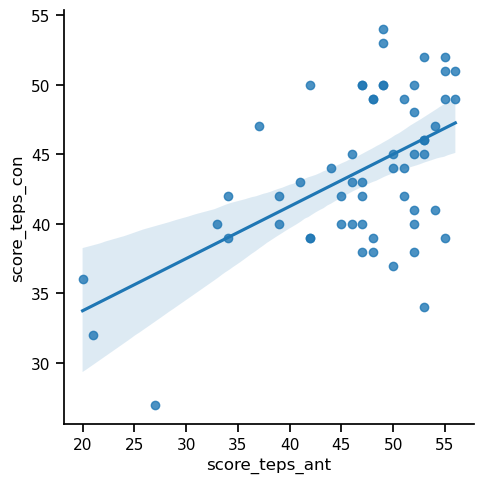

In [3]:
#VFITS
Fits=pd.read_csv('../derivatives/Fits_of_RT.csv')
Fits['Subject']=Fits['Sub']
display(Fits.head())
#RS
per_df=pd.read_excel('MID participant tracker_ 1.xlsx',sheet_name='model 4E basemodel 5')
per_df=per_df[~per_df['Subject'].isna()]
per_df['Subject']=per_df['Subject'].astype('int')
per_df['Subject']='sub-'+per_df['Subject'].astype('str')
display(per_df.head())
#teps
teps_df=pd.read_csv('temporal_experiences_of_pleasure.txt',sep='\t')
teps_df=teps_df[~teps_df['ID'].isna()]
teps_df['ID']=teps_df['ID'].astype('int')
teps_df['ID']='sub-'+teps_df['ID'].astype('str')
teps_df['Subject']=teps_df['ID']
teps_df=teps_df[teps_df['score_teps_ant']<900]
teps_df.head()
sms.lmplot(x='score_teps_ant',y='score_teps_con',data=teps_df)
r,p=pearsonr(teps_df['score_teps_ant'],teps_df['score_teps_con'])
print("Correlation is R^2: %s p: %s"%(r**2,p))
teps_df['mean_teps']=teps_df[['score_teps_ant','score_teps_con']].mean(axis=1)
teps_df.head()

per_df=pd.merge(per_df,teps_df,on='Subject')
total_df=pd.merge(Fits, per_df,on=['Subject'])


/ZPOOL/data/tools/anaconda/tuj71575/lib/python3.11/site-packages/nilearn/input_data/__init__.py:23: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


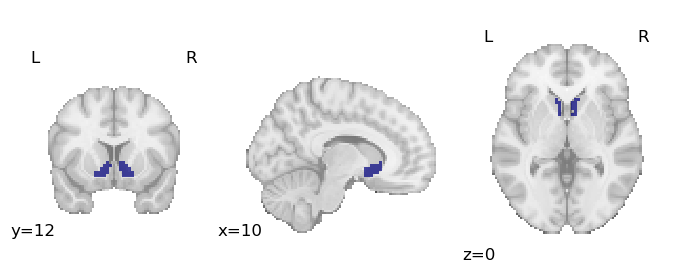

In [4]:
from nilearn import plotting, input_data
mask='../masks/seed-VS.nii.gz'

plotting.plot_roi(mask,draw_cross=False,cut_coords=[10,12,-0.5])
vs_masker=input_data.NiftiMasker(mask_img=mask)
plt.show()

In [5]:
cope_map={1:'Large Gain', 2: 'Small Gain',
          3: 'Large Loss', 4: 'Small Loss', 5: 'Hit',
         6:'Miss',7:'Neutral',8:'Gain>Loss',9:'Gain>Neut',
         10:'Loss>Neut',11:'Salience',12:'Hit-Miss',
          13:'LG-SG',14:'LL-SL'}
fsl_data='../derivatives/fsl'
data=[]
if os.path.exists('VS_activation_byCope.csv'):
    neuro_df=pd.read_csv('VS_activation_byCope.csv')
else:
    for sub in per_df['Subject']:
        for cope in [1,2,3,4,7,8,9,10,12,13,14,11]:
            L1_image='%s/%s/L1_task-mid_model-4_type-act_run-1.feat/stats/cope%s.nii.gz'%(
            fsl_data,sub,cope)
            L2_image='%s/%s/L2_task-mid_model-4_type-act.gfeat/cope%s.feat/stats/cope1.nii.gz'%(
            fsl_data,sub,cope)
            if os.path.isfile(L2_image):
                act_value_array=vs_masker.fit_transform(L2_image)
                act_value=np.mean(act_value_array)
                data.append([sub,cope,act_value])
            elif os.path.isfile(L1_image):
                act_value_array=vs_masker.fit_transform(L1_image)
                act_value=np.mean(act_value_array)
                data.append([sub,cope,act_value])
            else:
                print('%s has no data'%(sub))
    neuro_df=pd.DataFrame(data=data,columns=['Subject','Cope','Activation'])
    neuro_df['CopeName'] = neuro_df['Cope'].map(cope_map)
    neuro_df.to_csv('VS_activation_byCope.csv',index=False)

/tmp/ipykernel_9157/2934477264.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  sms.barplot(x='CopeName',y='Activation',palette=cmap,ci=68,


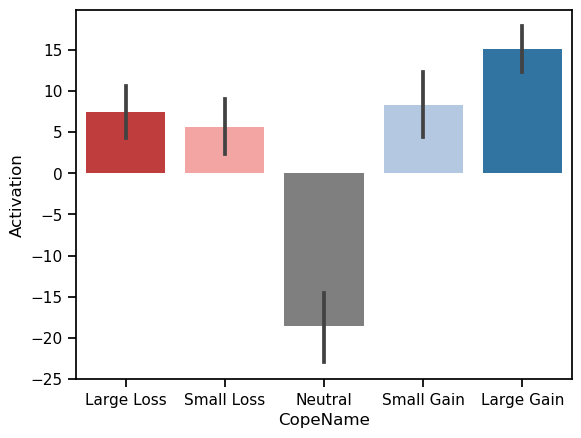

In [6]:
palette_tab20 = sms.color_palette("tab20", 20)
cmap = sms.color_palette([
    palette_tab20[6], palette_tab20[7],
    palette_tab20[14],
palette_tab20[1],palette_tab20[0]])
sms.barplot(x='CopeName',y='Activation',palette=cmap,ci=68,
            order=['Large Loss', 'Small Loss','Neutral','Small Gain', 'Large Gain'],data=neuro_df)
plt.savefig('Neural_Activation.svg')

In [7]:
neuro_df['Trial_code']=neuro_df['CopeName'].map(
    {"Large Loss":-2,"Small Loss":-1,"Neutral":0,"Small Gain":1,"Large Gain":2})
import statsmodels.formula.api as smf
results = smf.ols('Activation ~ Trial_code+I(Trial_code**2)',
                  data=neuro_df).fit()
display(results.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Activation   R-squared:                       0.097
Model:                            OLS   Adj. R-squared:                  0.089
Method:                 Least Squares   F-statistic:                     12.20
Date:                Thu, 27 Jul 2023   Prob (F-statistic):           9.31e-06
Time:                        15:53:53   Log-Likelihood:                -1076.3
No. Observations:                 230   AIC:                             2159.
Df Residuals:                     227   BIC:                             2169.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -6.1828      2.696     -2.293      0.023     -11.495      -0.870
Trial_code             1.7789      1.223      1.454      0.147      -0.632       4.189
I(Trial_code ** 2)     4.8800      1.034      4.720      0.000       2.843       6.917
==============================================================================
Omnibus:                        3.930   Durbin-Watson:                   1.246
Prob(Omnibus):                  0.140   Jarque-Bera (JB):                4.856
Skew:                          -0.036   Prob(JB):                       0.0882
Kurtosis:                       3.708   Cond. No.                         4.44
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [8]:
display(total_df.head())
display(neuro_df.head())
total_df=pd.merge(total_df,neuro_df,on='Subject')

,Sub,V_beta,LG-N,LL-N,rel_rew,Subject,Ones,tsnr_demean,fd_mean_demean,Composite_Reward,...,score_teps_q12,score_teps_q13,score_teps_q14,score_teps_q15,score_teps_q16,score_teps_q17,score_teps_q18,score_teps_ant,score_teps_con,mean_teps
0,sub-1001,-0.008537,-0.026752,-0.023816,-0.002937,sub-1001,1.0,-0.427375,0.048571,0.469388,...,6.0,6.0,6.0,6.0,6.0,6.0,6.0,52.0,40.0,46.0
1,sub-1003,-0.000617,0.054024,-0.014524,0.068547,sub-1003,1.0,-0.162367,0.124435,0.469388,...,2.0,6.0,6.0,4.0,4.0,6.0,6.0,48.0,38.0,43.0
2,sub-1004,-0.002456,0.020756,-0.019793,0.040550,sub-1004,1.0,-0.124384,-0.456402,2.469388,...,4.0,5.0,6.0,6.0,6.0,6.0,6.0,49.0,50.0,49.5
3,sub-1006,-0.005296,-0.023401,-0.022996,-0.000405,sub-1006,1.0,1.312499,-0.852311,-0.530612,...,4.0,2.0,5.0,2.0,2.0,5.0,3.0,33.0,40.0,36.5
4,sub-1009,-0.001678,-0.014629,-0.007453,-0.007177,sub-1009,1.0,1.190812,0.054972,1.469388,...,5.0,6.0,6.0,5.0,5.0,6.0,6.0,52.0,50.0,51.0


,Subject,Cope,Activation,CopeName,Trial_code
0,sub-1001,1,-19.701822,Large Gain,2.0
1,sub-1001,2,-33.419052,Small Gain,1.0
2,sub-1001,3,-15.890732,Large Loss,-2.0
3,sub-1001,4,-44.430430,Small Loss,-1.0
4,sub-1001,7,-14.523945,Neutral,0.0


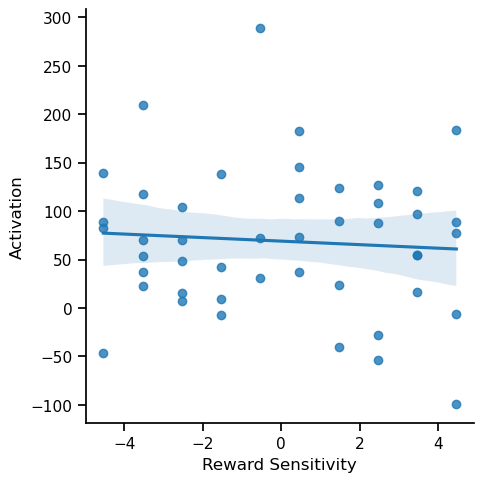

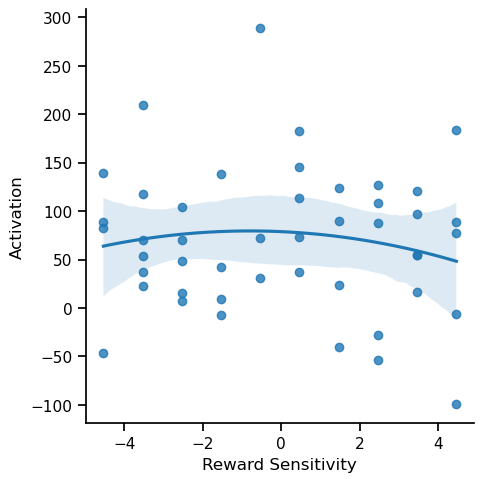

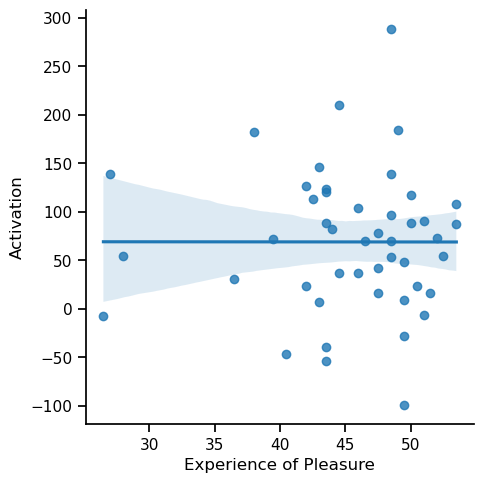

In [10]:
plt_df=total_df[total_df['CopeName']=='Salience']
x=['Composite_Reward','mean_teps','Composite_Reward_Squared_demean']

g=sms.lmplot(x=x[0],y='Activation',data=plt_df)
g.set(xlabel ="Reward Sensitivity")
plt.savefig("LinearReward_Salience.png")

g=sms.lmplot(x=x[0],y='Activation',data=plt_df,order=2)
g.set(xlabel ="Reward Sensitivity")
plt.savefig("QuadraticReward_Salience.png")

g=sms.lmplot(x=x[1],y='Activation',data=plt_df)
g.set(xlabel ="Experience of Pleasure")
plt.savefig("TEPS_Salience.png")

In [35]:
import statsmodels.formula.api as smf
for cope in total_df['CopeName'].unique():
    model_df=total_df[total_df['CopeName']==cope]
    results = smf.ols('Activation ~ Composite_Reward*mean_teps*Composite_Reward_Squared_demean+tsnr_demean+fd_mean_demean',
                          data=model_df).fit()
    if any(results.pvalues.values<0.05):
        print(cope)
        display(results.summary())

Large Loss


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Activation   R-squared:                       0.365
Model:                            OLS   Adj. R-squared:                  0.207
Method:                 Least Squares   F-statistic:                     2.302
Date:                Tue, 25 Jul 2023   Prob (F-statistic):             0.0368
Time:                        13:19:16   Log-Likelihood:                -194.25
No. Observations:                  46   AIC:                             408.5
Df Residuals:                      36   BIC:                             426.8
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================================================================
                                                                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------
Intercept                                                    -30.6367     25.080     -1.222      0.230     -81.501      20.228
Composite_Reward                                              30.8319     12.119      2.544      0.015       6.254      55.410
mean_teps                                                      0.8646      0.547      1.580      0.123      -0.245       1.974
Composite_Reward:mean_teps                                    -0.5763      0.259     -2.224      0.033      -1.102      -0.051
Composite_Reward_Squared_demean                               -4.4859      5.011     -0.895      0.377     -14.649       5.677
Composite_Reward:Composite_Reward_Squared_demean               0.5358      1.901      0.282      0.780      -3.320       4.392
mean_teps:Composite_Reward_Squared_demean                      0.1115      0.108      1.031      0.310      -0.108       0.331
Composite_Reward:mean_teps:Composite_Reward_Squared_demean    -0.0211      0.040     -0.523      0.604      -0.103       0.061
tsnr_demean                                                    0.8250      3.734      0.221      0.826      -6.747       8.397
fd_mean_demean                                                 3.4262      3.599      0.952      0.347      -3.873      10.725
==============================================================================
Omnibus:                        0.901   Durbin-Watson:                   2.109
Prob(Omnibus):                  0.637   Jarque-Bera (JB):                0.865
Skew:                          -0.310   Prob(JB):                        0.649
Kurtosis:                       2.740   Cond. No.                     1.09e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.09e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Gain>Loss


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Activation   R-squared:                       0.285
Model:                            OLS   Adj. R-squared:                  0.106
Method:                 Least Squares   F-statistic:                     1.595
Date:                Tue, 25 Jul 2023   Prob (F-statistic):              0.154
Time:                        13:19:16   Log-Likelihood:                -210.99
No. Observations:                  46   AIC:                             442.0
Df Residuals:                      36   BIC:                             460.3
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================================================================
                                                                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------
Intercept                                                    102.9094     36.091      2.851      0.007      29.713     176.106
Composite_Reward                                              -0.4354     17.439     -0.025      0.980     -35.804      34.933
mean_teps                                                     -2.0567      0.787     -2.613      0.013      -3.653      -0.460
Composite_Reward:mean_teps                                     0.0804      0.373      0.216      0.831      -0.676       0.837
Composite_Reward_Squared_demean                                1.3923      7.211      0.193      0.848     -13.232      16.017
Composite_Reward:Composite_Reward_Squared_demean              -2.8133      2.736     -1.028      0.311      -8.363       2.736
mean_teps:Composite_Reward_Squared_demean                     -0.0379      0.156     -0.244      0.809      -0.354       0.278
Composite_Reward:mean_teps:Composite_Reward_Squared_demean     0.0569      0.058      0.979      0.334      -0.061       0.175
tsnr_demean                                                   12.5361      5.373      2.333      0.025       1.640      23.433
fd_mean_demean                                                 4.8734      5.179      0.941      0.353      -5.630      15.377
==============================================================================
Omnibus:                        0.610   Durbin-Watson:                   1.856
Prob(Omnibus):                  0.737   Jarque-Bera (JB):                0.192
Skew:                          -0.143   Prob(JB):                        0.908
Kurtosis:                       3.137   Cond. No.                     1.09e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.09e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Hit-Miss


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Activation   R-squared:                       0.275
Model:                            OLS   Adj. R-squared:                  0.094
Method:                 Least Squares   F-statistic:                     1.517
Date:                Tue, 25 Jul 2023   Prob (F-statistic):              0.179
Time:                        13:19:16   Log-Likelihood:                -244.95
No. Observations:                  46   AIC:                             509.9
Df Residuals:                      36   BIC:                             528.2
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================================================================
                                                                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------
Intercept                                                    -11.4818     75.499     -0.152      0.880    -164.600     141.637
Composite_Reward                                             -21.5951     36.481     -0.592      0.558     -95.582      52.392
mean_teps                                                      1.4858      1.647      0.902      0.373      -1.854       4.826
Composite_Reward:mean_teps                                     0.3880      0.780      0.497      0.622      -1.194       1.970
Composite_Reward_Squared_demean                               33.3125     15.085      2.208      0.034       2.720      63.905
Composite_Reward:Composite_Reward_Squared_demean               4.0613      5.724      0.710      0.483      -7.547      15.670
mean_teps:Composite_Reward_Squared_demean                     -0.7212      0.326     -2.215      0.033      -1.381      -0.061
Composite_Reward:mean_teps:Composite_Reward_Squared_demean    -0.0829      0.122     -0.681      0.500      -0.330       0.164
tsnr_demean                                                    8.5115     11.239      0.757      0.454     -14.283      31.306
fd_mean_demean                                                 0.6688     10.834      0.062      0.951     -21.303      22.641
==============================================================================
Omnibus:                        7.815   Durbin-Watson:                   1.735
Prob(Omnibus):                  0.020   Jarque-Bera (JB):                8.721
Skew:                           0.559   Prob(JB):                       0.0128
Kurtosis:                       4.816   Cond. No.                     1.09e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.09e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

LL-SL


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Activation   R-squared:                       0.317
Model:                            OLS   Adj. R-squared:                  0.146
Method:                 Least Squares   F-statistic:                     1.855
Date:                Tue, 25 Jul 2023   Prob (F-statistic):             0.0915
Time:                        13:19:16   Log-Likelihood:                -189.10
No. Observations:                  46   AIC:                             398.2
Df Residuals:                      36   BIC:                             416.5
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================================================================
                                                                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------
Intercept                                                    -20.1648     22.421     -0.899      0.374     -65.637      25.308
Composite_Reward                                              26.3108     10.834      2.429      0.020       4.338      48.283
mean_teps                                                      0.5190      0.489      1.061      0.296      -0.473       1.511
Composite_Reward:mean_teps                                    -0.5357      0.232     -2.312      0.027      -1.006      -0.066
Composite_Reward_Squared_demean                               -4.0304      4.480     -0.900      0.374     -13.116       5.055
Composite_Reward:Composite_Reward_Squared_demean               1.4126      1.700      0.831      0.411      -2.035       4.860
mean_teps:Composite_Reward_Squared_demean                      0.0929      0.097      0.960      0.343      -0.103       0.289
Composite_Reward:mean_teps:Composite_Reward_Squared_demean    -0.0296      0.036     -0.820      0.418      -0.103       0.044
tsnr_demean                                                    2.1678      3.338      0.649      0.520      -4.601       8.937
fd_mean_demean                                                 1.9512      3.217      0.606      0.548      -4.574       8.476
==============================================================================
Omnibus:                       20.768   Durbin-Watson:                   1.936
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               39.280
Skew:                           1.239   Prob(JB):                     2.95e-09
Kurtosis:                       6.789   Cond. No.                     1.09e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.09e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [36]:
for cope in total_df['CopeName'].unique():
    model_df=total_df[total_df['CopeName']==cope]
    results = smf.ols('Activation ~ Composite_Reward*mean_teps+Composite_Reward_Squared_demean*mean_teps+tsnr_demean+fd_mean_demean',
                          data=model_df).fit()
    if any(results.pvalues.values<0.05):
        print(cope)
        display(results.summary())

Large Loss


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Activation   R-squared:                       0.252
Model:                            OLS   Adj. R-squared:                  0.114
Method:                 Least Squares   F-statistic:                     1.829
Date:                Tue, 25 Jul 2023   Prob (F-statistic):              0.110
Time:                        13:19:26   Log-Likelihood:                -198.03
No. Observations:                  46   AIC:                             412.1
Df Residuals:                      38   BIC:                             426.7
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=============================================================================================================
                                                coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
Intercept                                   -18.7669     25.798     -0.727      0.471     -70.991      33.458
Composite_Reward                             27.4904     10.737      2.560      0.015       5.755      49.225
mean_teps                                     0.6167      0.562      1.097      0.279      -0.521       1.754
Composite_Reward:mean_teps                   -0.5592      0.233     -2.396      0.022      -1.032      -0.087
Composite_Reward_Squared_demean               0.1026      4.471      0.023      0.982      -8.949       9.154
Composite_Reward_Squared_demean:mean_teps     0.0071      0.098      0.072      0.943      -0.191       0.205
tsnr_demean                                   0.5609      3.891      0.144      0.886      -7.316       8.438
fd_mean_demean                                1.7445      3.710      0.470      0.641      -5.766       9.255
==============================================================================
Omnibus:                        1.306   Durbin-Watson:                   2.294
Prob(Omnibus):                  0.521   Jarque-Bera (JB):                1.314
Skew:                          -0.341   Prob(JB):                        0.518
Kurtosis:                       2.529   Cond. No.                     2.91e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.91e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Gain>Loss


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Activation   R-squared:                       0.260
Model:                            OLS   Adj. R-squared:                  0.123
Method:                 Least Squares   F-statistic:                     1.905
Date:                Tue, 25 Jul 2023   Prob (F-statistic):             0.0958
Time:                        13:19:26   Log-Likelihood:                -211.79
No. Observations:                  46   AIC:                             439.6
Df Residuals:                      38   BIC:                             454.2
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=============================================================================================================
                                                coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
Intercept                                   100.1300     34.797      2.878      0.007      29.688     170.572
Composite_Reward                            -11.0860     14.482     -0.766      0.449     -40.403      18.231
mean_teps                                    -1.9785      0.758     -2.610      0.013      -3.513      -0.444
Composite_Reward:mean_teps                    0.2928      0.315      0.930      0.358      -0.345       0.930
Composite_Reward_Squared_demean               5.3530      6.031      0.888      0.380      -6.856      17.562
Composite_Reward_Squared_demean:mean_teps    -0.1174      0.132     -0.891      0.378      -0.384       0.149
tsnr_demean                                  11.5468      5.248      2.200      0.034       0.923      22.171
fd_mean_demean                                3.8843      5.004      0.776      0.442      -6.246      14.015
==============================================================================
Omnibus:                        1.058   Durbin-Watson:                   1.785
Prob(Omnibus):                  0.589   Jarque-Bera (JB):                0.562
Skew:                          -0.262   Prob(JB):                        0.755
Kurtosis:                       3.133   Cond. No.                     2.91e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.91e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Hit-Miss


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Activation   R-squared:                       0.263
Model:                            OLS   Adj. R-squared:                  0.128
Method:                 Least Squares   F-statistic:                     1.941
Date:                Tue, 25 Jul 2023   Prob (F-statistic):             0.0897
Time:                        13:19:26   Log-Likelihood:                -245.31
No. Observations:                  46   AIC:                             506.6
Df Residuals:                      38   BIC:                             521.2
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=============================================================================================================
                                                coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
Intercept                                    -6.7329     72.105     -0.093      0.926    -152.702     139.236
Composite_Reward                             -6.5688     30.009     -0.219      0.828     -67.319      54.181
mean_teps                                     1.3578      1.571      0.864      0.393      -1.822       4.538
Composite_Reward:mean_teps                    0.0852      0.652      0.131      0.897      -1.236       1.406
Composite_Reward_Squared_demean              27.9418     12.497      2.236      0.031       2.642      53.241
Composite_Reward_Squared_demean:mean_teps    -0.6142      0.273     -2.250      0.030      -1.167      -0.062
tsnr_demean                                   9.9103     10.875      0.911      0.368     -12.105      31.926
fd_mean_demean                                1.9752     10.370      0.190      0.850     -19.018      22.968
==============================================================================
Omnibus:                        7.641   Durbin-Watson:                   1.752
Prob(Omnibus):                  0.022   Jarque-Bera (JB):                8.128
Skew:                           0.575   Prob(JB):                       0.0172
Kurtosis:                       4.709   Cond. No.                     2.91e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.91e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

LL-SL


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Activation   R-squared:                       0.304
Model:                            OLS   Adj. R-squared:                  0.175
Method:                 Least Squares   F-statistic:                     2.367
Date:                Tue, 25 Jul 2023   Prob (F-statistic):             0.0413
Time:                        13:19:26   Log-Likelihood:                -189.54
No. Observations:                  46   AIC:                             395.1
Df Residuals:                      38   BIC:                             409.7
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=============================================================================================================
                                                coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
Intercept                                   -17.6177     21.450     -0.821      0.417     -61.040      25.805
Composite_Reward                             31.1135      8.927      3.485      0.001      13.042      49.185
mean_teps                                     0.4561      0.467      0.976      0.335      -0.490       1.402
Composite_Reward:mean_teps                   -0.6365      0.194     -3.280      0.002      -1.029      -0.244
Composite_Reward_Squared_demean              -5.4767      3.718     -1.473      0.149     -13.003       2.049
Composite_Reward_Squared_demean:mean_teps     0.1206      0.081      1.485      0.146      -0.044       0.285
tsnr_demean                                   2.6186      3.235      0.809      0.423      -3.930       9.168
fd_mean_demean                                2.2579      3.085      0.732      0.469      -3.987       8.503
==============================================================================
Omnibus:                       24.793   Durbin-Watson:                   1.978
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               55.990
Skew:                           1.409   Prob(JB):                     6.95e-13
Kurtosis:                       7.612   Cond. No.                     2.91e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.91e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [34]:
for cope in total_df['CopeName'].unique():
    model_df=total_df[total_df['CopeName']==cope]
    results = smf.ols('Activation ~ Composite_Reward+mean_teps+Composite_Reward_Squared_demean+tsnr_demean+fd_mean_demean',
                          data=model_df).fit()
    #if any(results.pvalues.values<0.05):
    print(cope)
    display(results.summary())

Large Gain


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Activation   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                 -0.078
Method:                 Least Squares   F-statistic:                    0.3454
Date:                Tue, 25 Jul 2023   Prob (F-statistic):              0.882
Time:                        13:11:18   Log-Likelihood:                -202.08
No. Observations:                  46   AIC:                             416.2
Df Residuals:                      40   BIC:                             427.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                          28.7015     24.035      1.194      0.239     -19.874      77.277
Composite_Reward                    1.0135      1.080      0.938      0.354      -1.170       3.197
mean_teps                          -0.2981      0.527     -0.566      0.575      -1.363       0.767
Composite_Reward_Squared_demean    -0.1666      0.459     -0.363      0.718      -1.093       0.760
tsnr_demean                         2.5995      4.011      0.648      0.521      -5.508      10.707
fd_mean_demean                      0.1266      3.891      0.033      0.974      -7.737       7.990
==============================================================================
Omnibus:                        2.743   Durbin-Watson:                   2.313
Prob(Omnibus):                  0.254   Jarque-Bera (JB):                2.602
Skew:                          -0.539   Prob(JB):                        0.272
Kurtosis:                       2.558   Cond. No.                         356.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Small Gain


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Activation   R-squared:                       0.167
Model:                            OLS   Adj. R-squared:                  0.063
Method:                 Least Squares   F-statistic:                     1.609
Date:                Tue, 25 Jul 2023   Prob (F-statistic):              0.180
Time:                        13:11:18   Log-Likelihood:                -214.31
No. Observations:                  46   AIC:                             440.6
Df Residuals:                      40   BIC:                             451.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                          20.3843     31.357      0.650      0.519     -42.991      83.759
Composite_Reward                    2.4963      1.410      1.771      0.084      -0.353       5.345
mean_teps                          -0.2774      0.687     -0.404      0.689      -1.667       1.112
Composite_Reward_Squared_demean     0.9727      0.598      1.626      0.112      -0.236       2.182
tsnr_demean                         6.2832      5.233      1.201      0.237      -4.294      16.860
fd_mean_demean                      3.9067      5.076      0.770      0.446      -6.352      14.166
==============================================================================
Omnibus:                        2.836   Durbin-Watson:                   2.132
Prob(Omnibus):                  0.242   Jarque-Bera (JB):                2.062
Skew:                           0.510   Prob(JB):                        0.357
Kurtosis:                       3.185   Cond. No.                         356.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Large Loss


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Activation   R-squared:                       0.111
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.9955
Date:                Tue, 25 Jul 2023   Prob (F-statistic):              0.433
Time:                        13:11:18   Log-Likelihood:                -202.01
No. Observations:                  46   AIC:                             416.0
Df Residuals:                      40   BIC:                             427.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                         -15.5557     24.000     -0.648      0.521     -64.061      32.950
Composite_Reward                    1.5768      1.079      1.462      0.152      -0.604       3.757
mean_teps                           0.5034      0.526      0.957      0.344      -0.560       1.567
Composite_Reward_Squared_demean     0.3476      0.458      0.759      0.452      -0.578       1.273
tsnr_demean                        -2.0273      4.006     -0.506      0.616     -10.123       6.068
fd_mean_demean                      0.0481      3.885      0.012      0.990      -7.804       7.900
==============================================================================
Omnibus:                        0.008   Durbin-Watson:                   2.629
Prob(Omnibus):                  0.996   Jarque-Bera (JB):                0.106
Skew:                          -0.026   Prob(JB):                        0.948
Kurtosis:                       2.770   Cond. No.                         356.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Small Loss


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Activation   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                 -0.085
Method:                 Least Squares   F-statistic:                    0.2960
Date:                Tue, 25 Jul 2023   Prob (F-statistic):              0.912
Time:                        13:11:18   Log-Likelihood:                -210.02
No. Observations:                  46   AIC:                             432.0
Df Residuals:                      40   BIC:                             443.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                         -15.4159     28.564     -0.540      0.592     -73.147      42.315
Composite_Reward                   -0.2381      1.284     -0.185      0.854      -2.833       2.357
mean_teps                           0.4593      0.626      0.734      0.468      -0.806       1.725
Composite_Reward_Squared_demean     0.4453      0.545      0.817      0.419      -0.656       1.547
tsnr_demean                        -1.9069      4.767     -0.400      0.691     -11.542       7.728
fd_mean_demean                     -0.7610      4.624     -0.165      0.870     -10.106       8.584
==============================================================================
Omnibus:                        1.760   Durbin-Watson:                   2.172
Prob(Omnibus):                  0.415   Jarque-Bera (JB):                1.640
Skew:                          -0.360   Prob(JB):                        0.440
Kurtosis:                       2.420   Cond. No.                         356.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Neutral


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Activation   R-squared:                       0.059
Model:                            OLS   Adj. R-squared:                 -0.059
Method:                 Least Squares   F-statistic:                    0.5025
Date:                Tue, 25 Jul 2023   Prob (F-statistic):              0.773
Time:                        13:11:18   Log-Likelihood:                -221.00
No. Observations:                  46   AIC:                             454.0
Df Residuals:                      40   BIC:                             465.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                         -12.9542     36.263     -0.357      0.723     -86.244      60.336
Composite_Reward                    2.4899      1.630      1.527      0.135      -0.805       5.784
mean_teps                          -0.1250      0.795     -0.157      0.876      -1.732       1.482
Composite_Reward_Squared_demean     0.0955      0.692      0.138      0.891      -1.303       1.494
tsnr_demean                        -1.4808      6.052     -0.245      0.808     -13.713      10.751
fd_mean_demean                     -0.8382      5.870     -0.143      0.887     -12.702      11.026
==============================================================================
Omnibus:                        3.221   Durbin-Watson:                   2.397
Prob(Omnibus):                  0.200   Jarque-Bera (JB):                2.156
Skew:                          -0.369   Prob(JB):                        0.340
Kurtosis:                       3.761   Cond. No.                         356.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Gain>Loss


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Activation   R-squared:                       0.238
Model:                            OLS   Adj. R-squared:                  0.143
Method:                 Least Squares   F-statistic:                     2.496
Date:                Tue, 25 Jul 2023   Prob (F-statistic):             0.0466
Time:                        13:11:18   Log-Likelihood:                -212.47
No. Observations:                  46   AIC:                             436.9
Df Residuals:                      40   BIC:                             447.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                          84.4997     30.124      2.805      0.008      23.616     145.383
Composite_Reward                    2.1327      1.354      1.575      0.123      -0.604       4.870
mean_teps                          -1.6339      0.660     -2.474      0.018      -2.969      -0.299
Composite_Reward_Squared_demean     0.0257      0.575      0.045      0.965      -1.136       1.187
tsnr_demean                        12.3899      5.028      2.464      0.018       2.229      22.551
fd_mean_demean                      4.4532      4.877      0.913      0.367      -5.403      14.309
==============================================================================
Omnibus:                        0.666   Durbin-Watson:                   1.751
Prob(Omnibus):                  0.717   Jarque-Bera (JB):                0.472
Skew:                          -0.245   Prob(JB):                        0.790
Kurtosis:                       2.924   Cond. No.                         356.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Gain>Neut


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Activation   R-squared:                       0.062
Model:                            OLS   Adj. R-squared:                 -0.055
Method:                 Least Squares   F-statistic:                    0.5316
Date:                Tue, 25 Jul 2023   Prob (F-statistic):              0.751
Time:                        13:11:18   Log-Likelihood:                -242.34
No. Observations:                  46   AIC:                             496.7
Df Residuals:                      40   BIC:                             507.7
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                          76.3496     57.672      1.324      0.193     -40.210     192.909
Composite_Reward                   -1.4535      2.593     -0.561      0.578      -6.693       3.786
mean_teps                          -0.3459      1.264     -0.274      0.786      -2.901       2.209
Composite_Reward_Squared_demean     0.5558      1.100      0.505      0.616      -1.668       2.780
tsnr_demean                        11.8601      9.625      1.232      0.225      -7.593      31.314
fd_mean_demean                      5.8285      9.336      0.624      0.536     -13.040      24.697
==============================================================================
Omnibus:                        0.260   Durbin-Watson:                   2.178
Prob(Omnibus):                  0.878   Jarque-Bera (JB):                0.005
Skew:                          -0.007   Prob(JB):                        0.998
Kurtosis:                       3.047   Cond. No.                         356.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Loss>Neut


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Activation   R-squared:                       0.062
Model:                            OLS   Adj. R-squared:                 -0.055
Method:                 Least Squares   F-statistic:                    0.5290
Date:                Tue, 25 Jul 2023   Prob (F-statistic):              0.753
Time:                        13:11:18   Log-Likelihood:                -247.90
No. Observations:                  46   AIC:                             507.8
Df Residuals:                      40   BIC:                             518.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                         -10.6754     65.081     -0.164      0.871    -142.210     120.859
Composite_Reward                   -3.6575      2.926     -1.250      0.219      -9.570       2.255
mean_teps                           1.3444      1.427      0.942      0.352      -1.539       4.228
Composite_Reward_Squared_demean     0.5627      1.242      0.453      0.653      -1.947       3.072
tsnr_demean                        -0.6291     10.862     -0.058      0.954     -22.582      21.324
fd_mean_demean                      1.4171     10.535      0.135      0.894     -19.876      22.710
==============================================================================
Omnibus:                        8.105   Durbin-Watson:                   2.587
Prob(Omnibus):                  0.017   Jarque-Bera (JB):                8.132
Skew:                           0.663   Prob(JB):                       0.0171
Kurtosis:                       4.576   Cond. No.                         356.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Hit-Miss


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Activation   R-squared:                       0.144
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     1.341
Date:                Tue, 25 Jul 2023   Prob (F-statistic):              0.267
Time:                        13:11:18   Log-Likelihood:                -248.78
No. Observations:                  46   AIC:                             509.6
Df Residuals:                      40   BIC:                             520.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                         -82.4531     66.334     -1.243      0.221    -216.519      51.613
Composite_Reward                   -4.4981      2.982     -1.508      0.139     -10.525       1.529
mean_teps                           2.9135      1.454      2.004      0.052      -0.025       5.852
Composite_Reward_Squared_demean    -0.1352      1.266     -0.107      0.915      -2.693       2.423
tsnr_demean                         7.5438     11.071      0.681      0.500     -14.832      29.919
fd_mean_demean                      0.5117     10.738      0.048      0.962     -21.191      22.214
==============================================================================
Omnibus:                        5.066   Durbin-Watson:                   1.819
Prob(Omnibus):                  0.079   Jarque-Bera (JB):                3.932
Skew:                           0.543   Prob(JB):                        0.140
Kurtosis:                       3.935   Cond. No.                         356.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

LG-SG


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Activation   R-squared:                       0.199
Model:                            OLS   Adj. R-squared:                  0.099
Method:                 Least Squares   F-statistic:                     1.993
Date:                Tue, 25 Jul 2023   Prob (F-statistic):              0.101
Time:                        13:11:18   Log-Likelihood:                -205.76
No. Observations:                  46   AIC:                             423.5
Df Residuals:                      40   BIC:                             434.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                           7.3287     26.038      0.281      0.780     -45.296      59.954
Composite_Reward                   -1.5185      1.170     -1.297      0.202      -3.884       0.847
mean_teps                           0.0073      0.571      0.013      0.990      -1.146       1.161
Composite_Reward_Squared_demean    -1.1763      0.497     -2.368      0.023      -2.180      -0.172
tsnr_demean                        -3.7581      4.346     -0.865      0.392     -12.541       5.025
fd_mean_demean                     -3.7782      4.215     -0.896      0.375     -12.297       4.741
==============================================================================
Omnibus:                        0.203   Durbin-Watson:                   2.441
Prob(Omnibus):                  0.903   Jarque-Bera (JB):                0.202
Skew:                          -0.138   Prob(JB):                        0.904
Kurtosis:                       2.828   Cond. No.                         356.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

LL-SL


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Activation   R-squared:                       0.106
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                    0.9532
Date:                Tue, 25 Jul 2023   Prob (F-statistic):              0.458
Time:                        13:11:18   Log-Likelihood:                -195.27
No. Observations:                  46   AIC:                             402.5
Df Residuals:                      40   BIC:                             413.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                          -0.1509     20.730     -0.007      0.994     -42.047      41.746
Composite_Reward                    1.9608      0.932      2.104      0.042       0.077       3.844
mean_teps                           0.0447      0.454      0.098      0.922      -0.874       0.963
Composite_Reward_Squared_demean    -0.0501      0.395     -0.127      0.900      -0.849       0.749
tsnr_demean                         0.1793      3.460      0.052      0.959      -6.813       7.172
fd_mean_demean                      0.6431      3.356      0.192      0.849      -6.139       7.425
==============================================================================
Omnibus:                        3.672   Durbin-Watson:                   2.068
Prob(Omnibus):                  0.159   Jarque-Bera (JB):                2.547
Skew:                           0.437   Prob(JB):                        0.280
Kurtosis:                       3.752   Cond. No.                         356.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Salience


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Activation   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                 -0.103
Method:                 Least Squares   F-statistic:                    0.1574
Date:                Tue, 25 Jul 2023   Prob (F-statistic):              0.977
Time:                        13:11:19   Log-Likelihood:                -261.78
No. Observations:                  46   AIC:                             535.6
Df Residuals:                      40   BIC:                             546.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                          47.3892     88.012      0.538      0.593    -130.490     225.268
Composite_Reward                   -2.0381      3.956     -0.515      0.609     -10.034       5.958
mean_teps                           0.4894      1.929      0.254      0.801      -3.410       4.389
Composite_Reward_Squared_demean    -1.1975      1.679     -0.713      0.480      -4.591       2.196
tsnr_demean                        -0.5755     14.689     -0.039      0.969     -30.263      29.112
fd_mean_demean                     -1.2546     14.247     -0.088      0.930     -30.050      27.540
==============================================================================
Omnibus:                        2.172   Durbin-Watson:                   2.791
Prob(Omnibus):                  0.338   Jarque-Bera (JB):                1.339
Skew:                           0.387   Prob(JB):                        0.512
Kurtosis:                       3.315   Cond. No.                         356.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

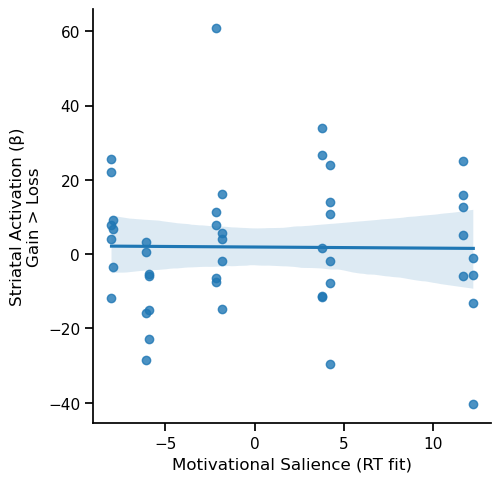

In [64]:
cope='Gain>Loss'
x=['Composite_Reward','mean_teps','Composite_Reward_Squared_demean', 'Salience']
plt_df=total_df[total_df['CopeName']==cope]
g=sms.lmplot(x=x[0],y='Activation',data=plt_df)
g.set(xlabel ="Trait Reward Sensitivity", ylabel='Striatal Activation (β)\nGain > Loss')
plt.savefig("figures/LinearReward_Gain-Loss_VSact.svg")

g=sms.lmplot(x=x[0],y='Activation',data=plt_df,order=2)
g.set(xlabel ="Trait Reward Sensitivity", ylabel='Striatal Activation (β)\nGain > Loss')
plt.savefig("figures/QuadraticReward_Gain-Loss_VSact.svg")

g=sms.lmplot(x=x[1],y='Activation',data=plt_df)
g.set(xlabel ="Trait Experience of Pleasure", ylabel='Striatal Activation (β)\nGain > Loss')
plt.savefig("figures/TEPS_Gain-Loss_VSact.svg")

g=sms.lmplot(x=x[2],y='Activation',data=plt_df)
g.set(xlabel ="Motivational Salience (RT fit)", ylabel='Striatal Activation (β)\nGain > Loss')
plt.savefig("figures/RTsalience_Gain-Loss_VSact.svg")

In [46]:
total_df['CopeName'].unique()

array(['Large Gain', 'Small Gain', 'Large Loss', 'Small Loss', 'Neutral',
       'Gain>Loss', 'Gain>Neut', 'Loss>Neut', 'Hit-Miss', 'LG-SG',
       'LL-SL', 'Salience'], dtype=object)

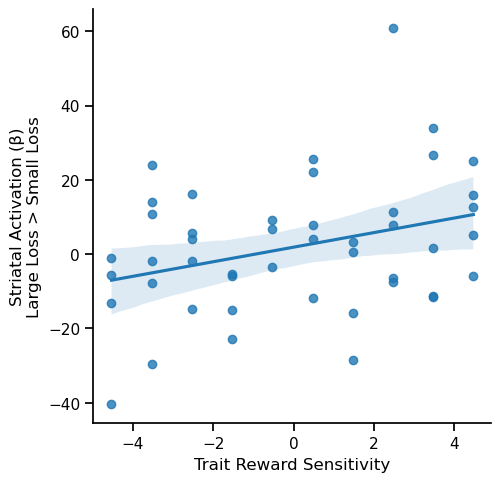

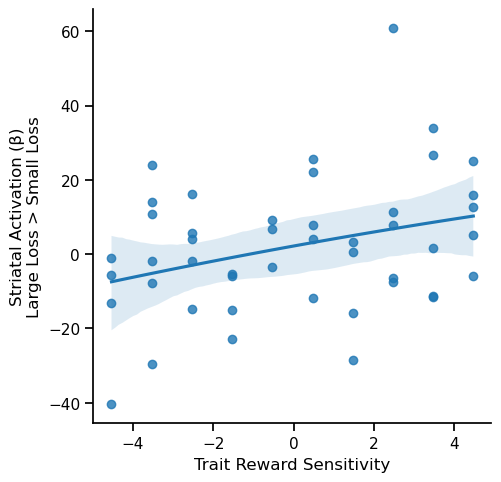

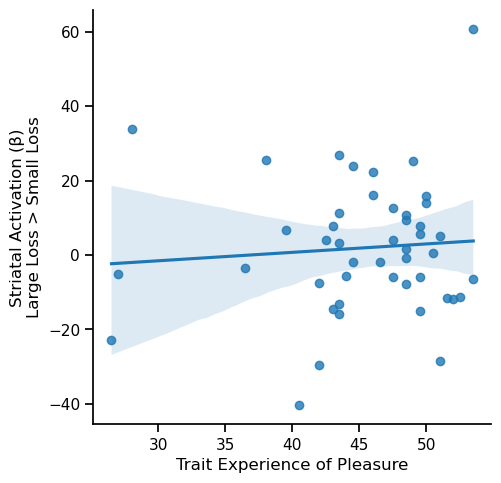

In [63]:
cope='LL-SL'
x=['Composite_Reward','mean_teps','Composite_Reward_Squared_demean']
plt_df=total_df[total_df['CopeName']==cope]
g=sms.lmplot(x=x[0],y='Activation',data=plt_df)
g.set(xlabel ="Trait Reward Sensitivity", ylabel='Striatal Activation (β)\nLarge Loss > Small Loss')
plt.savefig("figures/LinearReward_Loss_VSact.svg")

g=sms.lmplot(x=x[0],y='Activation',data=plt_df,order=2)
g.set(xlabel ="Trait Reward Sensitivity", ylabel='Striatal Activation (β)\nLarge Loss > Small Loss')
plt.savefig("figures/QuadraticReward_Loss_VSact.svg")

g=sms.lmplot(x=x[1],y='Activation',data=plt_df)
g.set(xlabel ="Trait Experience of Pleasure", ylabel='Striatal Activation (β)\nLarge Loss > Small Loss')
plt.savefig("figures/TEPS_Loss_VSact.svg")

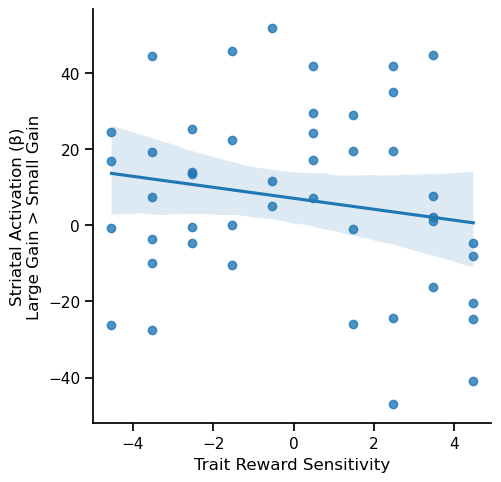

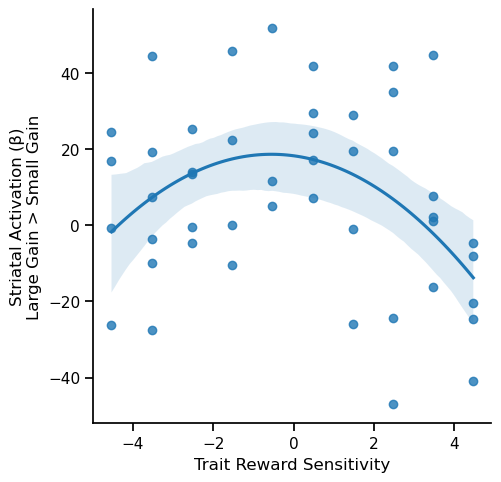

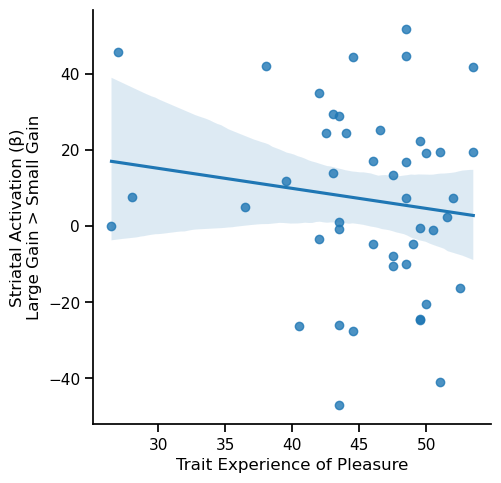

In [12]:
cope='LG-SG'
x=['Composite_Reward','mean_teps','Composite_Reward_Squared_demean']
plt_df=total_df[total_df['CopeName']==cope]
g=sms.lmplot(x=x[0],y='Activation',data=plt_df)
g.set(xlabel ="Trait Reward Sensitivity", ylabel='Striatal Activation (β)\nLarge Gain > Small Gain')
plt.savefig("figures/LinearReward_Gain_VSact.png")

g=sms.lmplot(x=x[0],y='Activation',data=plt_df,order=2)
g.set(xlabel ="Trait Reward Sensitivity", ylabel='Striatal Activation (β)\nLarge Gain > Small Gain')
plt.savefig("figures/QuadraticReward_Gain_VSact.png")

g=sms.lmplot(x=x[1],y='Activation',data=plt_df)
g.set(xlabel ="Trait Experience of Pleasure", ylabel='Striatal Activation (β)\nLarge Gain > Small Gain')
plt.savefig("figures/TEPS_Gain_VSact.png")

Large Gain
R: 0.13026883169334624 p: 0.3881943851370933


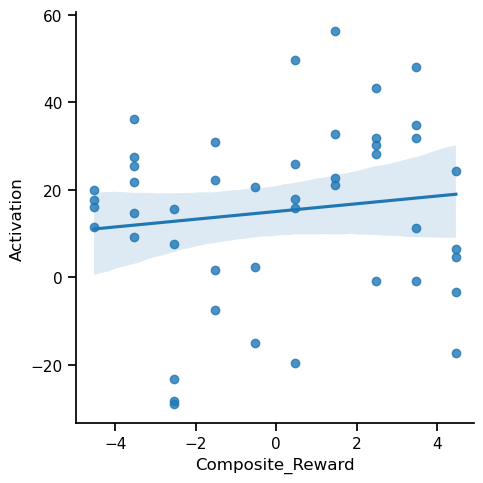

R: -0.051772726953209294 p: 0.7325725647438481


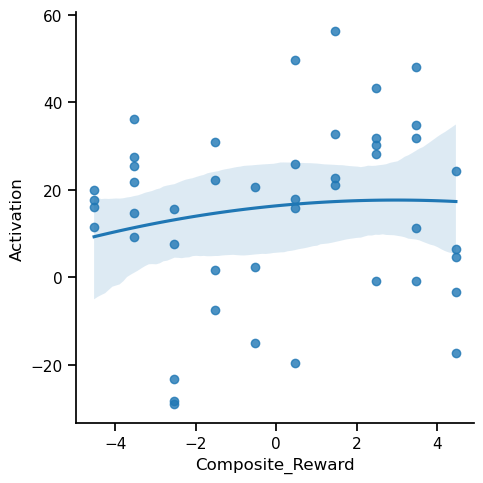

R: -0.060694458760385345 p: 0.6886477930333241


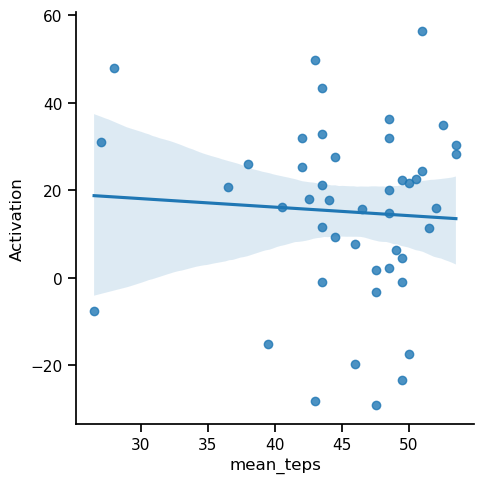

R: -0.30102773033066244 p: 0.04206217970347034


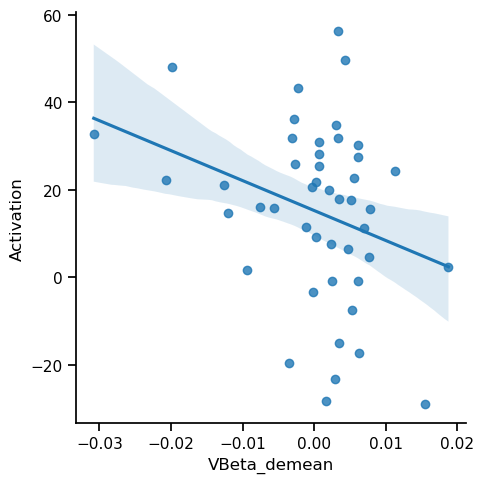

Small Gain
R: 0.24238630800124145 p: 0.10458793980922262


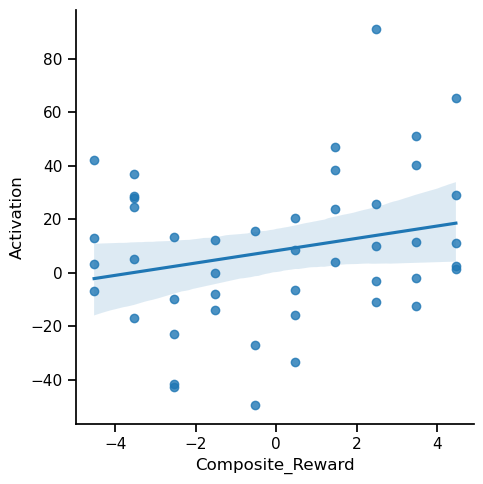

R: 0.2806024542007061 p: 0.05890415346103991


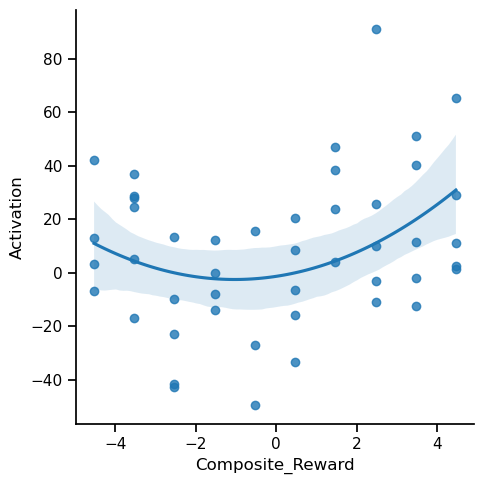

R: 0.07729263074459382 p: 0.6096577317356682


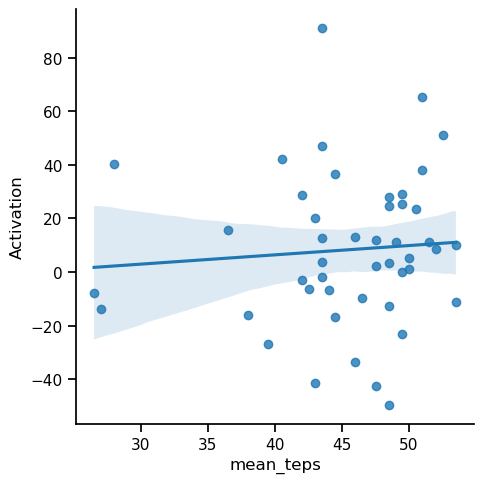

R: -0.2599311098221249 p: 0.0810636930322361


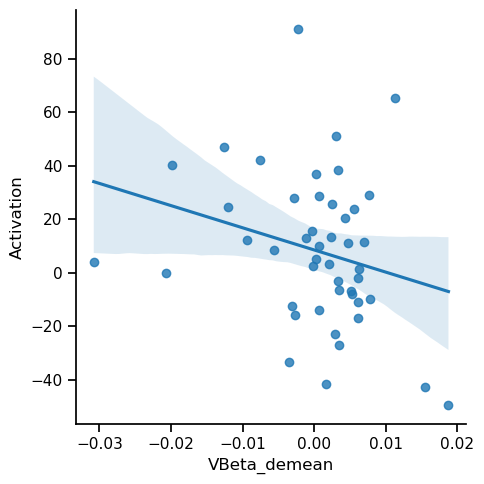

Large Loss
R: 0.25470920911446415 p: 0.08758397225510103


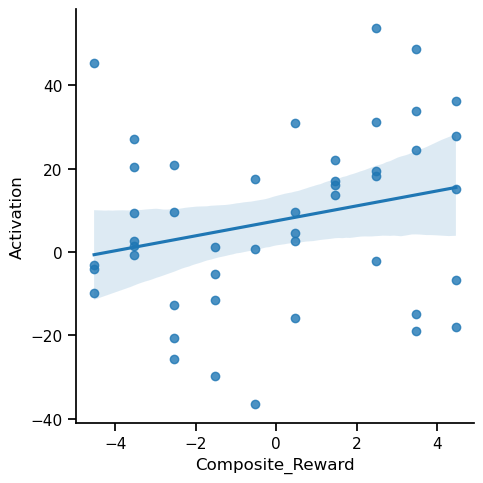

R: 0.1326553398425276 p: 0.3794854476020795


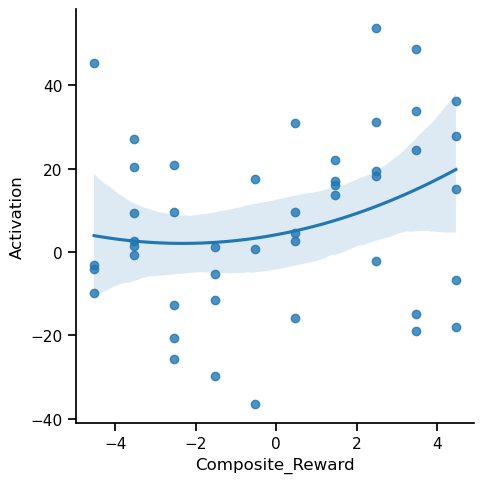

R: 0.209642266444717 p: 0.16201491871622725


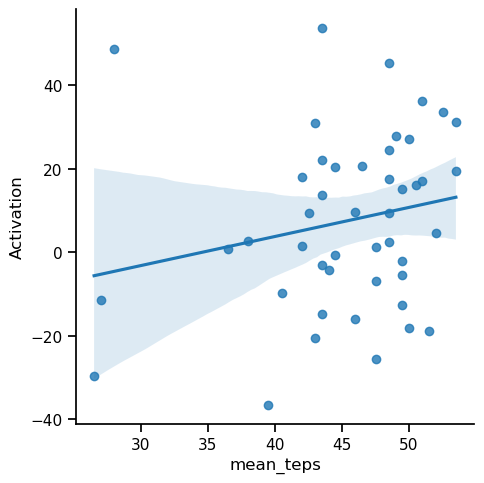

R: -0.1243422490255185 p: 0.41032406784241493


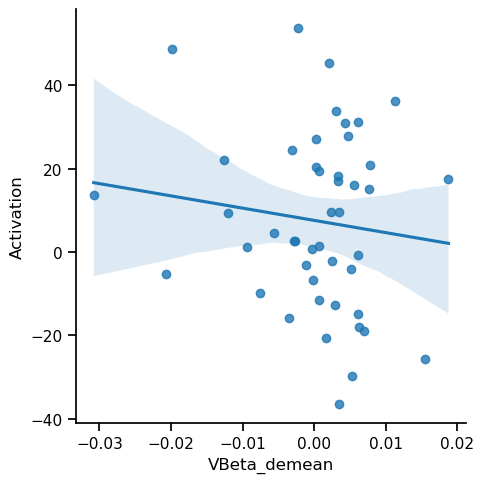

Small Loss
R: -0.0025433834749837847 p: 0.9866158372256546


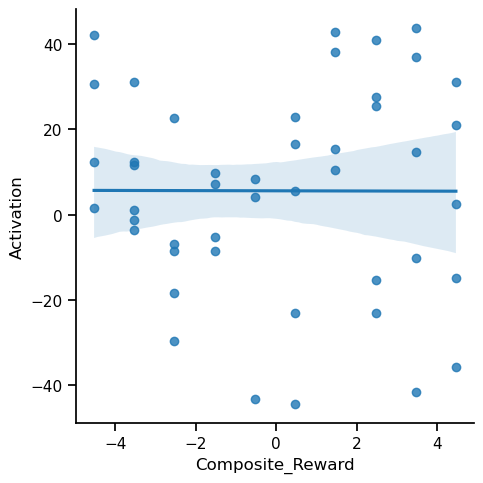

R: 0.14176288662259698 p: 0.34733041227142175


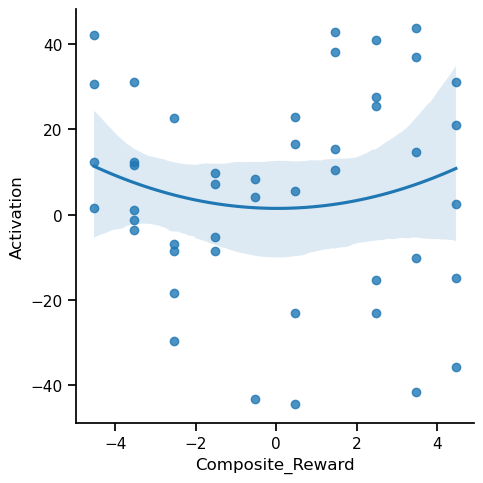

R: 0.13126111958051712 p: 0.3845591093800896


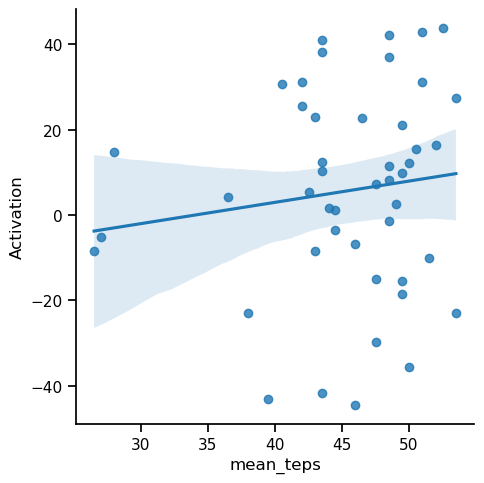

R: -0.17549816781754346 p: 0.2433677787318131


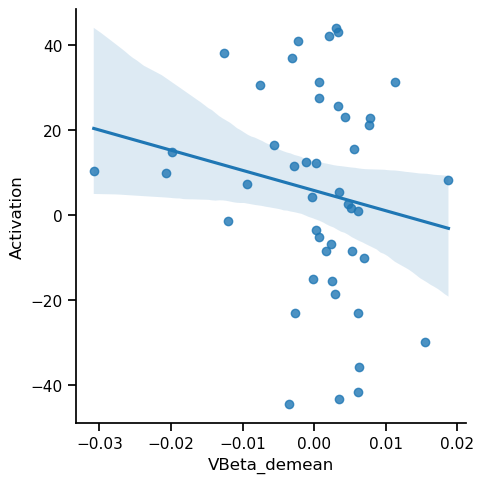

Neutral
R: 0.2380883231049194 p: 0.11107911514417951


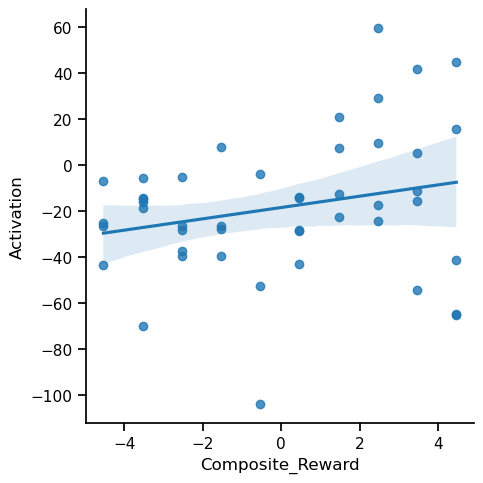

R: 0.008657554658025035 p: 0.9544627864836346


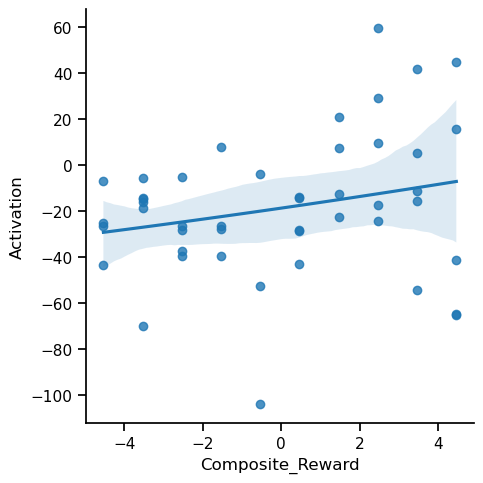

R: 0.018869153119776917 p: 0.9009464595057299


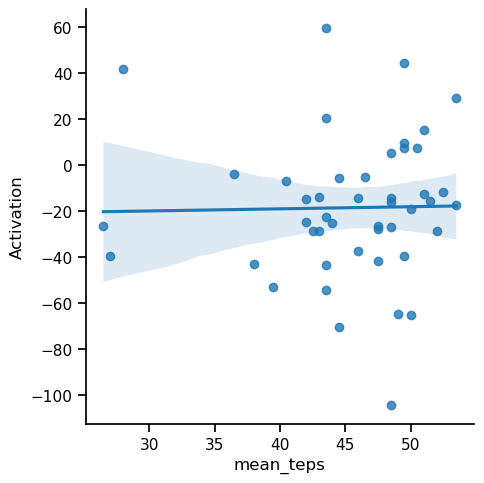

R: -0.3163167992164191 p: 0.03222155316327401


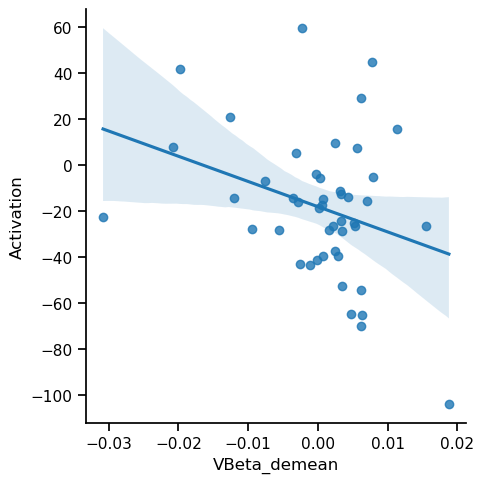

Gain>Loss
R: 0.14093006839902267 p: 0.3501991694055492


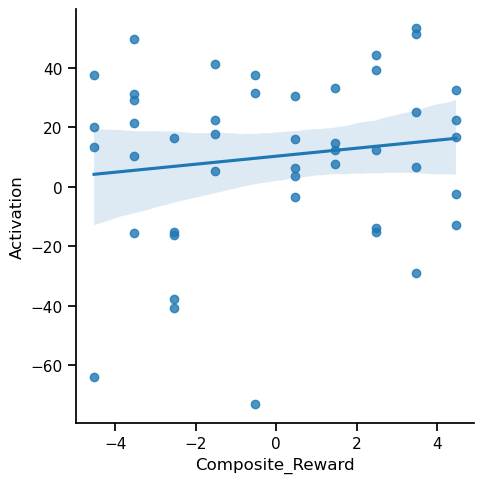

R: 0.020874885274590436 p: 0.8904783872834299


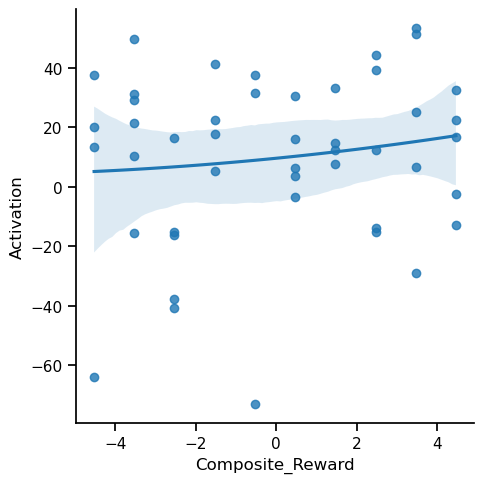

R: -0.25539799715171907 p: 0.08670126115596363


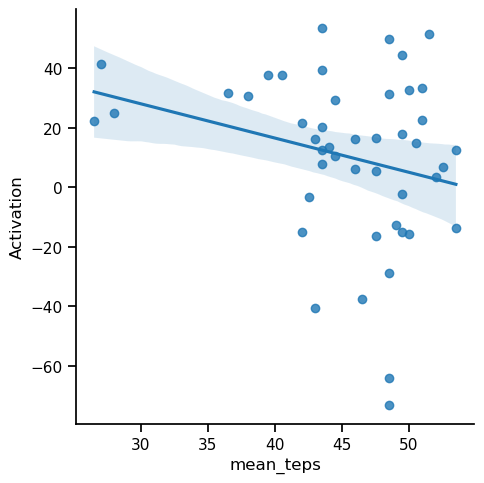

R: -0.24000544117468406 p: 0.10814680062869572


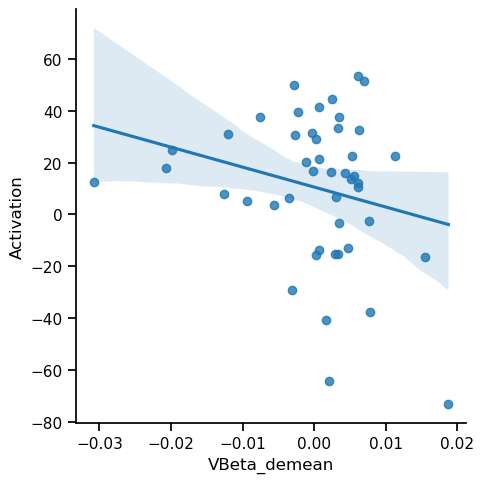

Gain>Neut
R: -0.10509393812007167 p: 0.4869962677178318


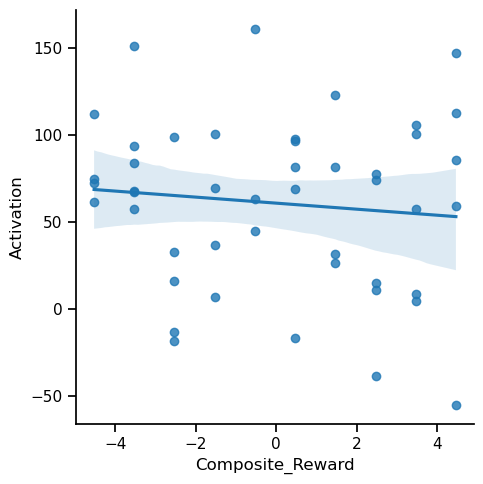

R: 0.12062397307793872 p: 0.42456956987557093


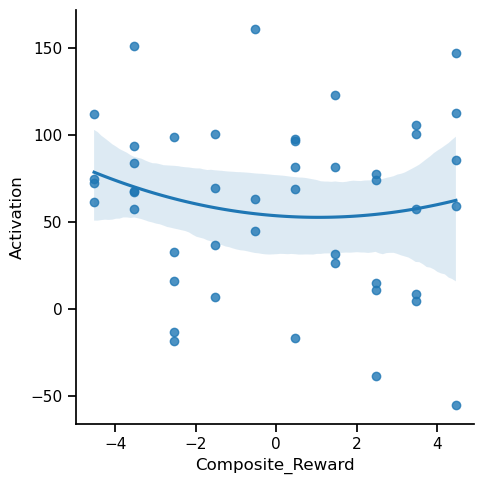

R: -0.008095530725048365 p: 0.9574161278370967


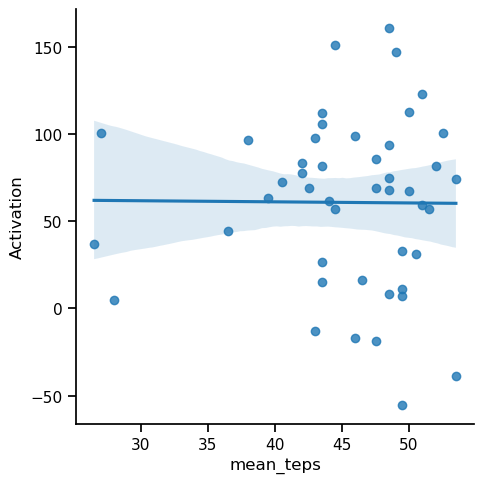

R: 0.12252406107084696 p: 0.4172553670186005


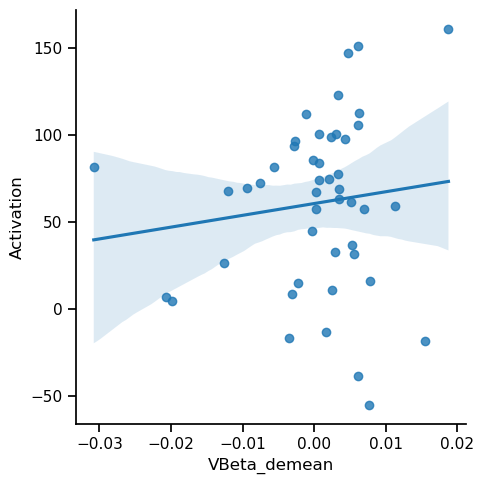

Loss>Neut
R: -0.16810459626481897 p: 0.26410837465228343


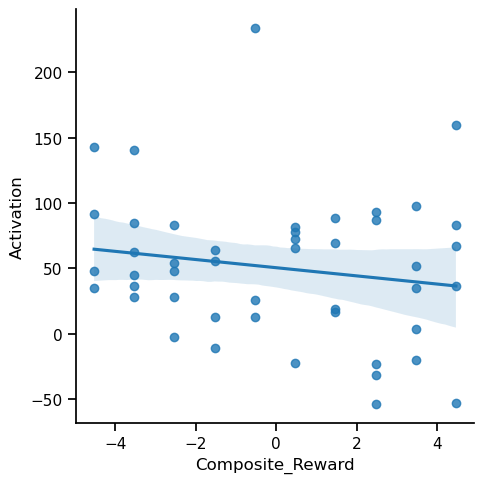

R: 0.10136574117306155 p: 0.5026631263095069


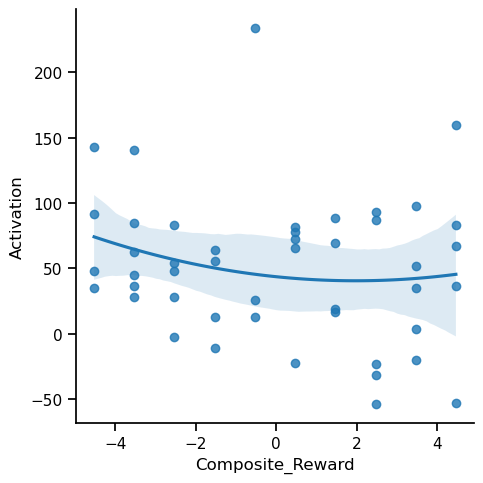

R: 0.13037020521669807 p: 0.38782207614557623


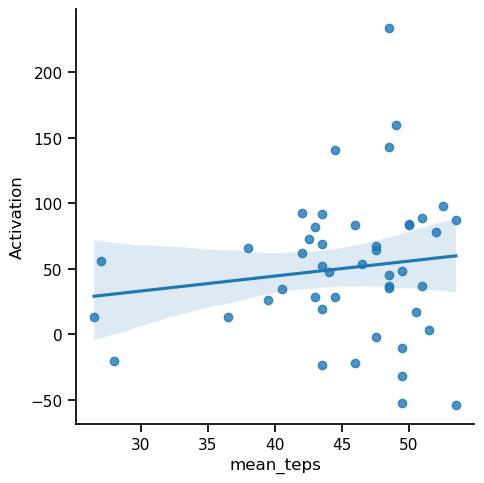

R: 0.23187287920130634 p: 0.12100334933405135


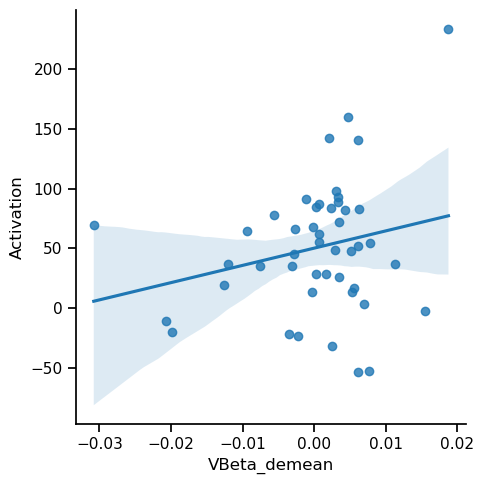

Hit-Miss
R: -0.16630550423288404 p: 0.2693280422679065


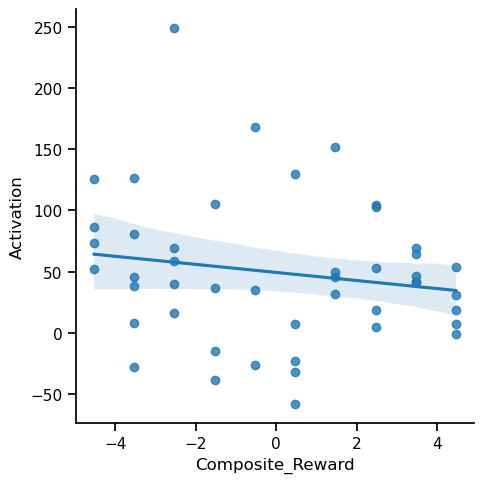

R: 0.0721752910696159 p: 0.6335990050794994


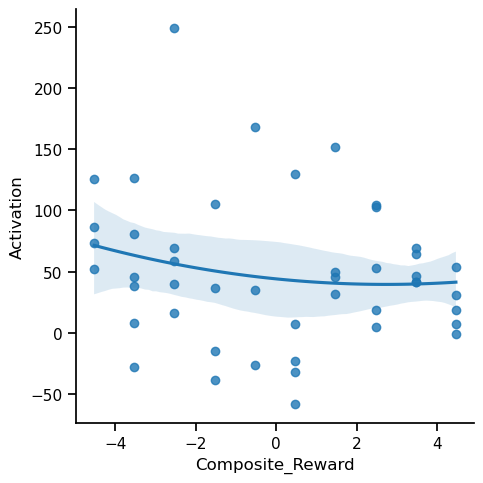

R: 0.278725876944703 p: 0.060689917326157986


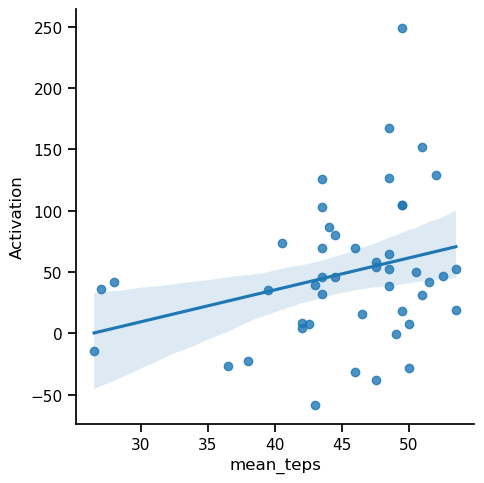

R: 0.0059265938005789165 p: 0.9688184700204965


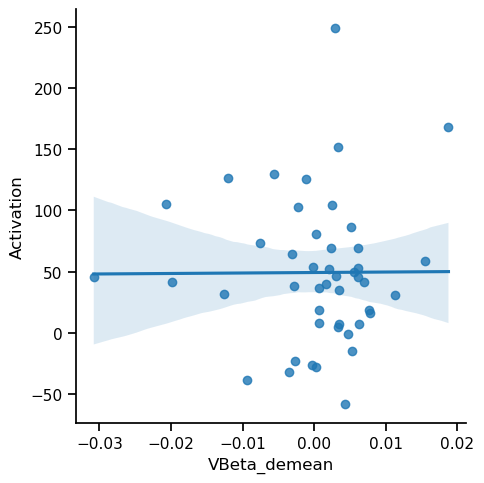

LG-SG
R: -0.17941834321178152 p: 0.23283165267595163


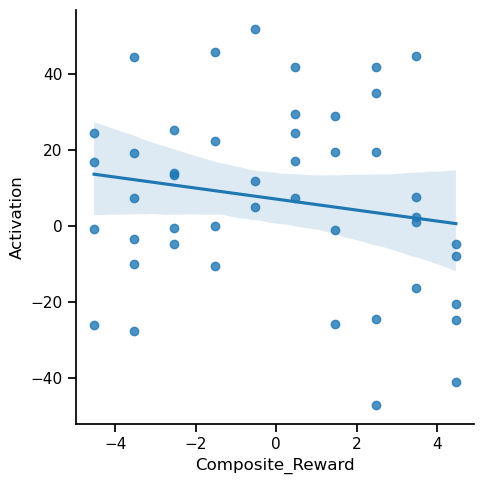

R: -0.38521000343724265 p: 0.008202926449112294


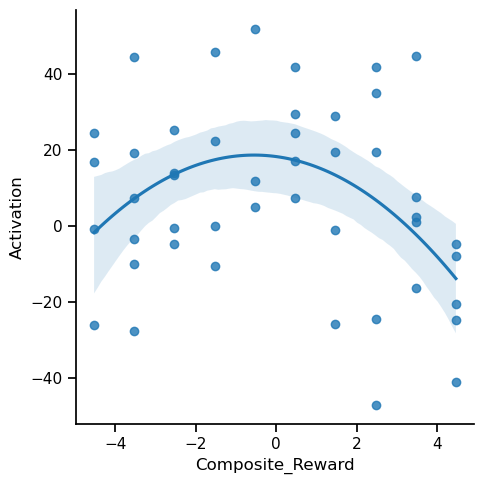

R: -0.13861266182220194 p: 0.3582578658031328


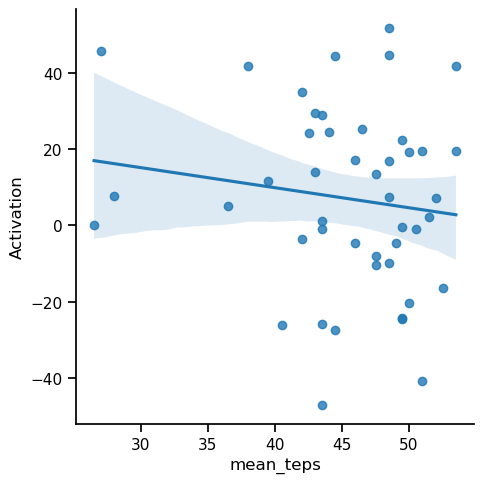

R: 0.05367308410073238 p: 0.723139667717795


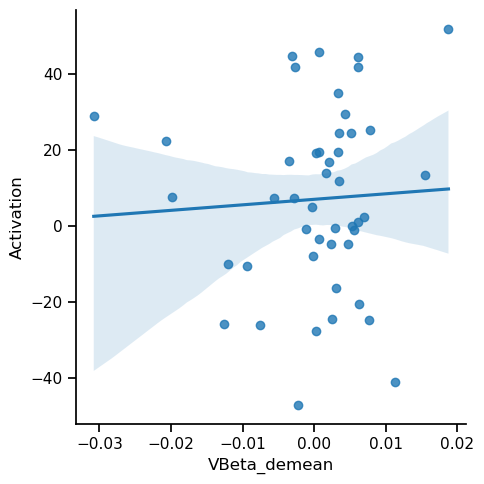

LL-SL
R: 0.32389990727583096 p: 0.028098158712409577


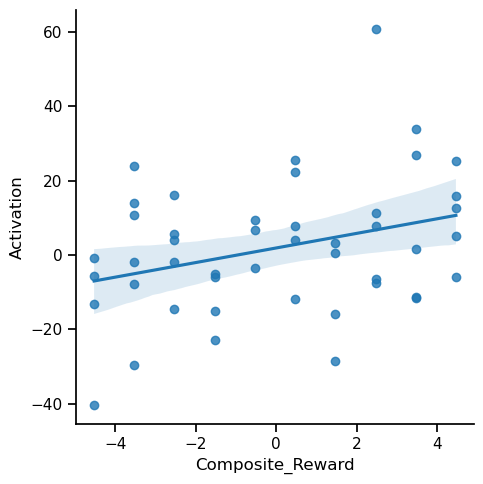

R: -0.011864423167505897 p: 0.9376239490808497


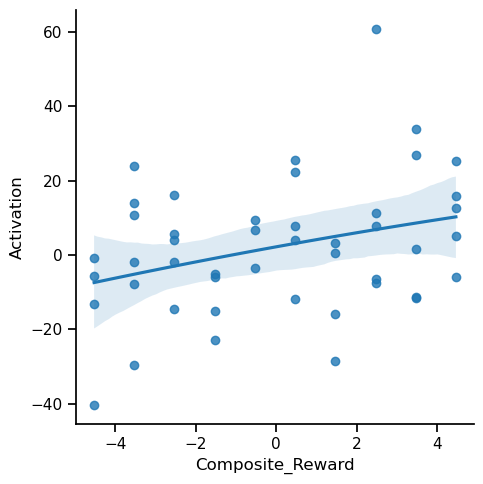

R: 0.07924888494859861 p: 0.6006092195901269


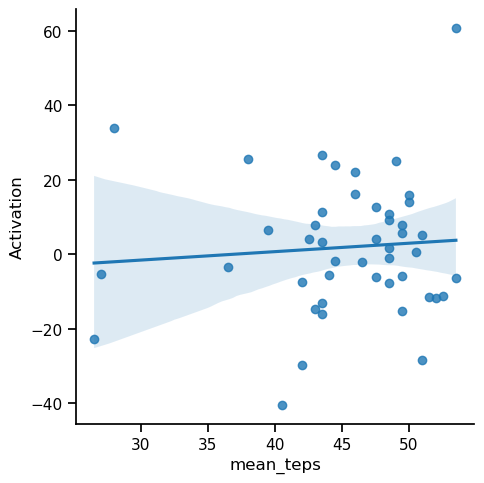

R: 0.0801373998954931 p: 0.5965189084757662


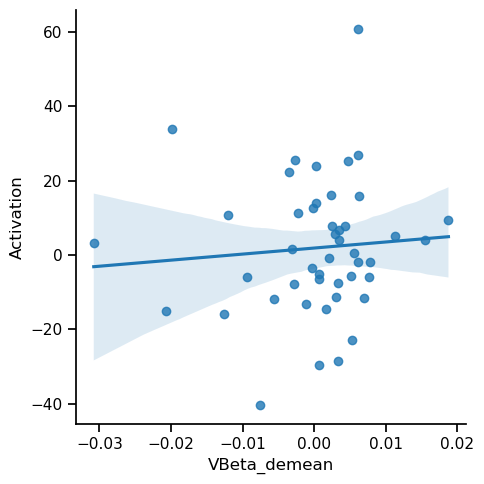

Salience
R: -0.0742236863779478 p: 0.6239693341877877


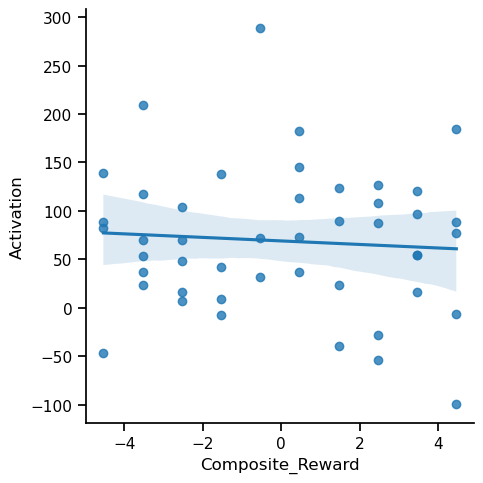

R: -0.1106266430256046 p: 0.4642243672545603


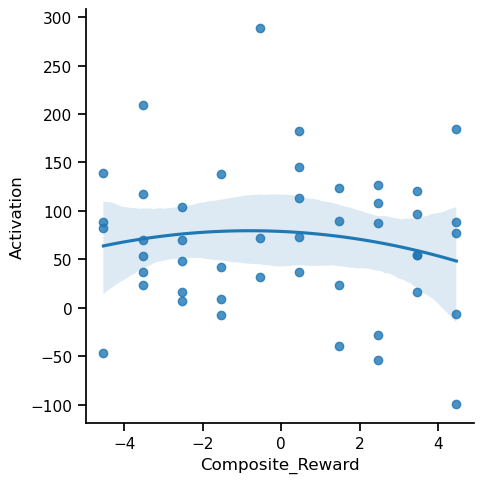

R: -0.0007218338946250874 p: 0.9962013024489417


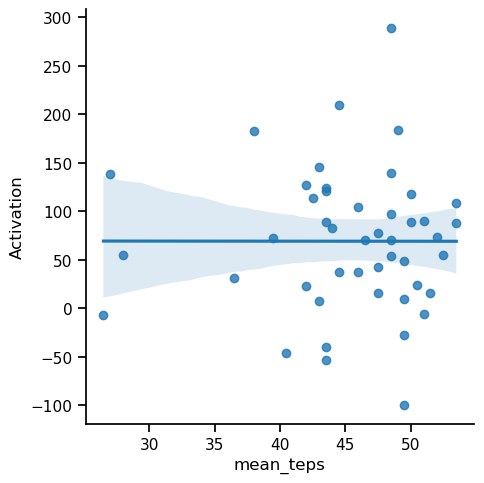

R: 0.1834309900996933 p: 0.22237499262318067


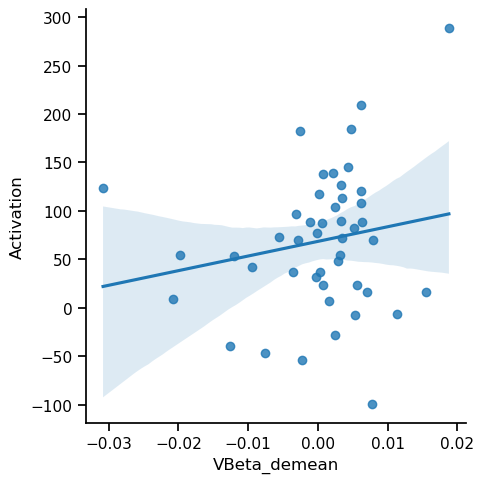

In [80]:
for cope in total_df['CopeName'].unique():
    plt_df=total_df[total_df['CopeName']==cope]
    print(cope)
    plt_df['CopeName'].unique()
    r,p=pearsonr(plt_df['Composite_Reward'],plt_df['Activation'])
    print("R: %s p: %s"%(r,p))
    sms.lmplot(x='Composite_Reward',y='Activation',data=plt_df)
    plt.show()
    r,p=pearsonr(plt_df['Composite_Reward_Squared_demean'],plt_df['Activation'])
    print("R: %s p: %s"%(r,p))
    sms.lmplot(x='Composite_Reward',y='Activation',data=plt_df,order=2)
    plt.show()
    r,p=pearsonr(plt_df['mean_teps'],plt_df['Activation'])
    print("R: %s p: %s"%(r,p))
    sms.lmplot(x='mean_teps',y='Activation',data=plt_df,order=1)
    plt.show()
    r,p=pearsonr(plt_df['VBeta_demean'],plt_df['Activation'])
    print("R: %s p: %s"%(r,p))
    sms.lmplot(x='VBeta_demean',y='Activation',data=plt_df,order=1)
    plt.show()